In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from collections import Counter
import pickle

In [17]:
RW_dataset_path = "C:\\Users\\hp-pc\\Desktop\\GRP\\real_data\\fusion\\fusion_total\\fusion_total.csv"

In [18]:
df_fusion_RW = pd.read_csv(RW_dataset_path, index_col=False)

In [19]:
df_fusion_RW = df_fusion_RW.dropna()

In [20]:
df_fusion_RW.pop('time')
df_fusion_RW.pop('posx')
df_fusion_RW.pop('posy')
df_fusion_RW.pop('yaw')
df_fusion_RW.pop('yaw_error')

0       -46.419603
1       -47.866942
2       -48.417687
3       -41.905376
4       -28.993614
           ...    
28464    -6.581422
28465    -6.184947
28466    -5.723173
28467    -5.343430
28468    -5.063220
Name: yaw_error, Length: 28469, dtype: float64

In [21]:
def change_yaw(x):
    if x < 0:
        x += 360
    return x

df_fusion_RW['yaw_c'] = df_fusion_RW['yaw_c'].apply(change_yaw)
yaw_c_RW = df_fusion_RW.pop("yaw_c")
yaw_c_RW = yaw_c_RW * np.pi / 180 # deg to rad

df_fusion_RW['Cx'] = np.cos(yaw_c_RW)
df_fusion_RW['Cy'] = np.sin(yaw_c_RW)

In [22]:
def change_winddir(x):
    if x < 0:
        x += 360
    return x

df_fusion_RW['winddir'] = df_fusion_RW['winddir'].apply(change_winddir)
winddir = df_fusion_RW.pop("winddir")
winddir = winddir * np.pi / 180

df_fusion_RW['windvx'] = df_fusion_RW['windv']*np.cos(winddir)
df_fusion_RW['windvy'] = df_fusion_RW['windv']*np.sin(winddir)

In [23]:
winddir = df_fusion_RW.pop("windv")

In [24]:
df_fusion_RW = df_fusion_RW[['windvx', 'windvy', 'con', 'detection', 'Cx', 'Cy']]

In [25]:
mean = df_fusion_RW.mean()
std = df_fusion_RW.std()
df_fusion_RW = (df_fusion_RW - mean) / std

In [26]:
train_df = df_fusion_RW[0:int(len(df_fusion_RW) * 0.8)]
val_df = df_fusion_RW[int(len(df_fusion_RW) * 0.8):int(len(df_fusion_RW) * 0.9)]
test_df = df_fusion_RW[int(len(df_fusion_RW) * 0.9):]

In [27]:
# define the window_generator function
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None,
                 input_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        self.input_columns = input_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Input column names: {self.input_columns}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        if self.input_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=16, )

        ds = ds.map(self.split_window)

        return ds
    
    # convert DataFrame into Dataset
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    # fetch an example batch for plotting
    def example(self):
        # by default, call example function returns None
        result = getattr(self, '_example', None)
        if result is None:
            # no example batch was found, so get one from the '.train' dataset
            # iter: creates an iterator object
            result = next(iter(self.train))
            # and cache it for the next time
            self._example = result

        return result

    def plot(self, model=None, plot_col='Yaw_e', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        # find the index of the column that the user wants to plot
        plot_col_index = self.column_indices[plot_col]
        # only plots maximal 3 batches of data
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n + 1)
            plt.ylabel(f'{plot_col}[normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                # get: method returns the value of the item (index) with the specified key (name)
                # get(keyname, value=None)
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                # with the continue statement, we can stop the current iteration of the for loop
                # and continue with the next
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k',
                        label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()

        plt.xlabel('Time[s]')
        plt.show()


In [28]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history


In [29]:
columns = df_fusion_RW.columns
label_columns = ['Cx', 'Cy']
input_columns = list((Counter(columns) - Counter(label_columns)).elements())
num_inputs = len(input_columns)

In [30]:
filter_size = 64
lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.LSTM(256, return_sequences=True),
        # tf.keras.layers.LSTM(64, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=filter_size, activation='relu'),
        tf.keras.layers.Dense(units=filter_size, activation='relu'),
        tf.keras.layers.Dense(units=2)
    ])

In [31]:
CONV_WIDTH = 6

lstm_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=CONV_WIDTH,
    shift=0,
    train_df=train_df,
    test_df=test_df,
    val_df=val_df,
    label_columns=label_columns,
    input_columns=input_columns
)

In [32]:
history = compile_and_fit(lstm_model, lstm_window)

val_performance = lstm_model.evaluate(lstm_window.test)
print(val_performance, sum(val_performance))

Epoch 1/20
1424/1424 [==============================] - 42s 27ms/step - loss: 0.6051 - mean_absolute_error: 0.5646 - val_loss: 0.3291 - val_mean_absolute_error: 0.4413
Epoch 2/20
1424/1424 [==============================] - 40s 28ms/step - loss: 0.5600 - mean_absolute_error: 0.5292 - val_loss: 0.3343 - val_mean_absolute_error: 0.4358
Epoch 3/20
178/178 [==============================] - 1s 7ms/step - loss: 0.4114 - mean_absolute_error: 0.4911
[0.411382794380188, 0.4911445081233978] 0.9025273025035858


In [33]:
acc = history.history['mean_absolute_error']
val_acc = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

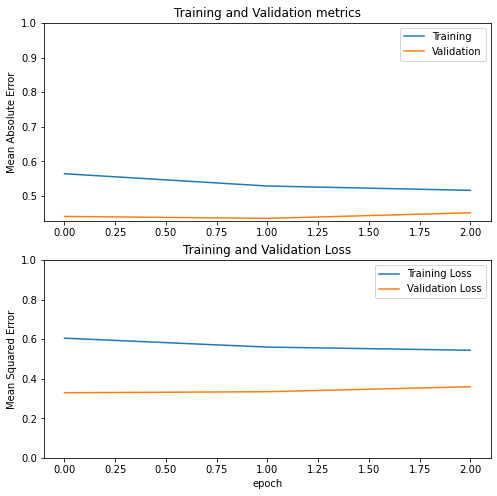

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Mean Absolute Error')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation metrics')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig("RW_fusion_rnn.jpg")
plt.show()